# General

**Available traffic count data:**
- BAST traffic count for whole Germany (2003 until 2018) [Map BAST stations Germany](https://tumde-my.sharepoint.com/:b:/g/personal/johannes_gensheimer_tum_de/EdDBb-siKZZIvjM8kKd5olIBrPItB3HQSb1ywU1tE6uhyA?e=5wtxzx)
- BAYSIS traffic count data for Bavaria (2017 until April 2020) [Map BASIS stations Germany](https://tumde-my.sharepoint.com/:b:/g/personal/johannes_gensheimer_tum_de/EdUoyfWh8GtLi3qA_hgaZjgBUpgirz1mRd0ZUiAI5OKQLw?e=klBvtc)\
    --> BAYSIS is acutally also included in BAST but much more recent data is available for BAYSIS 
- vehicle separation: KFZ: all vehicles, SV: Schwerverkehr (heavy vehciles), PKW: Personenkraftwagen (light vehicles)

**Available Corona Mobility reports:**
- BAST: weekly values for 03/2020 until 06/2020 referenced to the time frame 02/02/2020 until 03/07/2020 for traffic decrease for whole Germany
- Apple: daily values of the decrease in route requests for Germany and sub regions referenced to 01/13/2020
- TomTom: daily values of traffic congestion for 25 cities in Germany in relation to the correlated day in 2019
- Google: daily values where people are referenced to the median of 01/03/2020 - 02/06/2020

**Why is it necessary to estimate the traffic of Germany?**
- no continuous data for traffic in Germany
- reference value of mobility reports is not available (no traffic count data for whole Germany)
- there is a seasonal cycle in traffic in Germany so e.g. the mobility report of BAST references to 02/2020 but for this timeframe no traffic count data is available for whole Germany 

--> we have to create this reference data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from scipy.stats import pearsonr
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size':18})

# Read data

In [2]:
#BAST
df_Bast_KFZ = pd.read_csv('../data/mobility/BAST_CountingStations_Feature_monthly.csv',index_col='date')
df_Bast_SV = pd.read_csv('../data/mobility/BAST_CountingStations_Feature_monthly_SV.csv',index_col='date')

df_Bast = df_Bast_KFZ
df_Bast = df_Bast.rename(columns={'M_BAST_AverTotalVehicPerCountingStation': 'BAST_KFZ'})
df_Bast['BAST_SV'] = df_Bast_SV.M_BAST_AverTotalVehicPerCountingStation
df_Bast['BAST_PKW'] = df_Bast.BAST_KFZ - df_Bast.BAST_SV

#Bavarian stations in BAST dataset
df_BastBay_KFZ = pd.read_csv('../data/mobility/BAST_Bavaria_CountingStations_Feature_monthly.csv',index_col='date')
df_BastBay_SV = pd.read_csv('../data/mobility/BAST_Bavaria_CountingStations_Feature_monthly_SV.csv',index_col='date')

df_BastBay = df_BastBay_KFZ
df_BastBay = df_BastBay.rename(columns={'M_BAST_Bavaria_AverTotalVehicPerCountingStation': 'BASTBay_KFZ'})

df_BastBay['BASTBay_SV'] = df_BastBay_SV.M_BAST_Bavaria_AverTotalVehicPerCountingStation_SV
df_BastBay['BASTBay_PKW'] = df_BastBay.BASTBay_KFZ - df_BastBay.BASTBay_SV

#BAYSIS stations
df_Baysis_KFZ = pd.read_csv('../data/mobility/Baysis_CountingStations_Feature_monthly.csv', index_col='date')
df_Baysis_SV = pd.read_csv('../data/mobility/Baysis_CountingStations_Feature_monthly_SV.csv',index_col='date')

df_Baysis = df_Baysis_KFZ
df_Baysis = df_Baysis.rename(columns={'M_BaysisCount_AverTotalVehicPerCountingStation': 'BAYSIS_KFZ'})
df_Baysis['BAYSIS_SV'] = df_Baysis_SV.M_BaysisCount_AverTotalVehicPerCountingStation
df_Baysis['BAYSIS_PKW'] = df_Baysis.BAYSIS_KFZ - df_Baysis.BAYSIS_SV

#BAST Mobility Report
df_Bast_MR = pd.read_csv('../data/mobility/BASTMobilityReport_monthly.csv',index_col='date')


# Investigate data

In [3]:
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

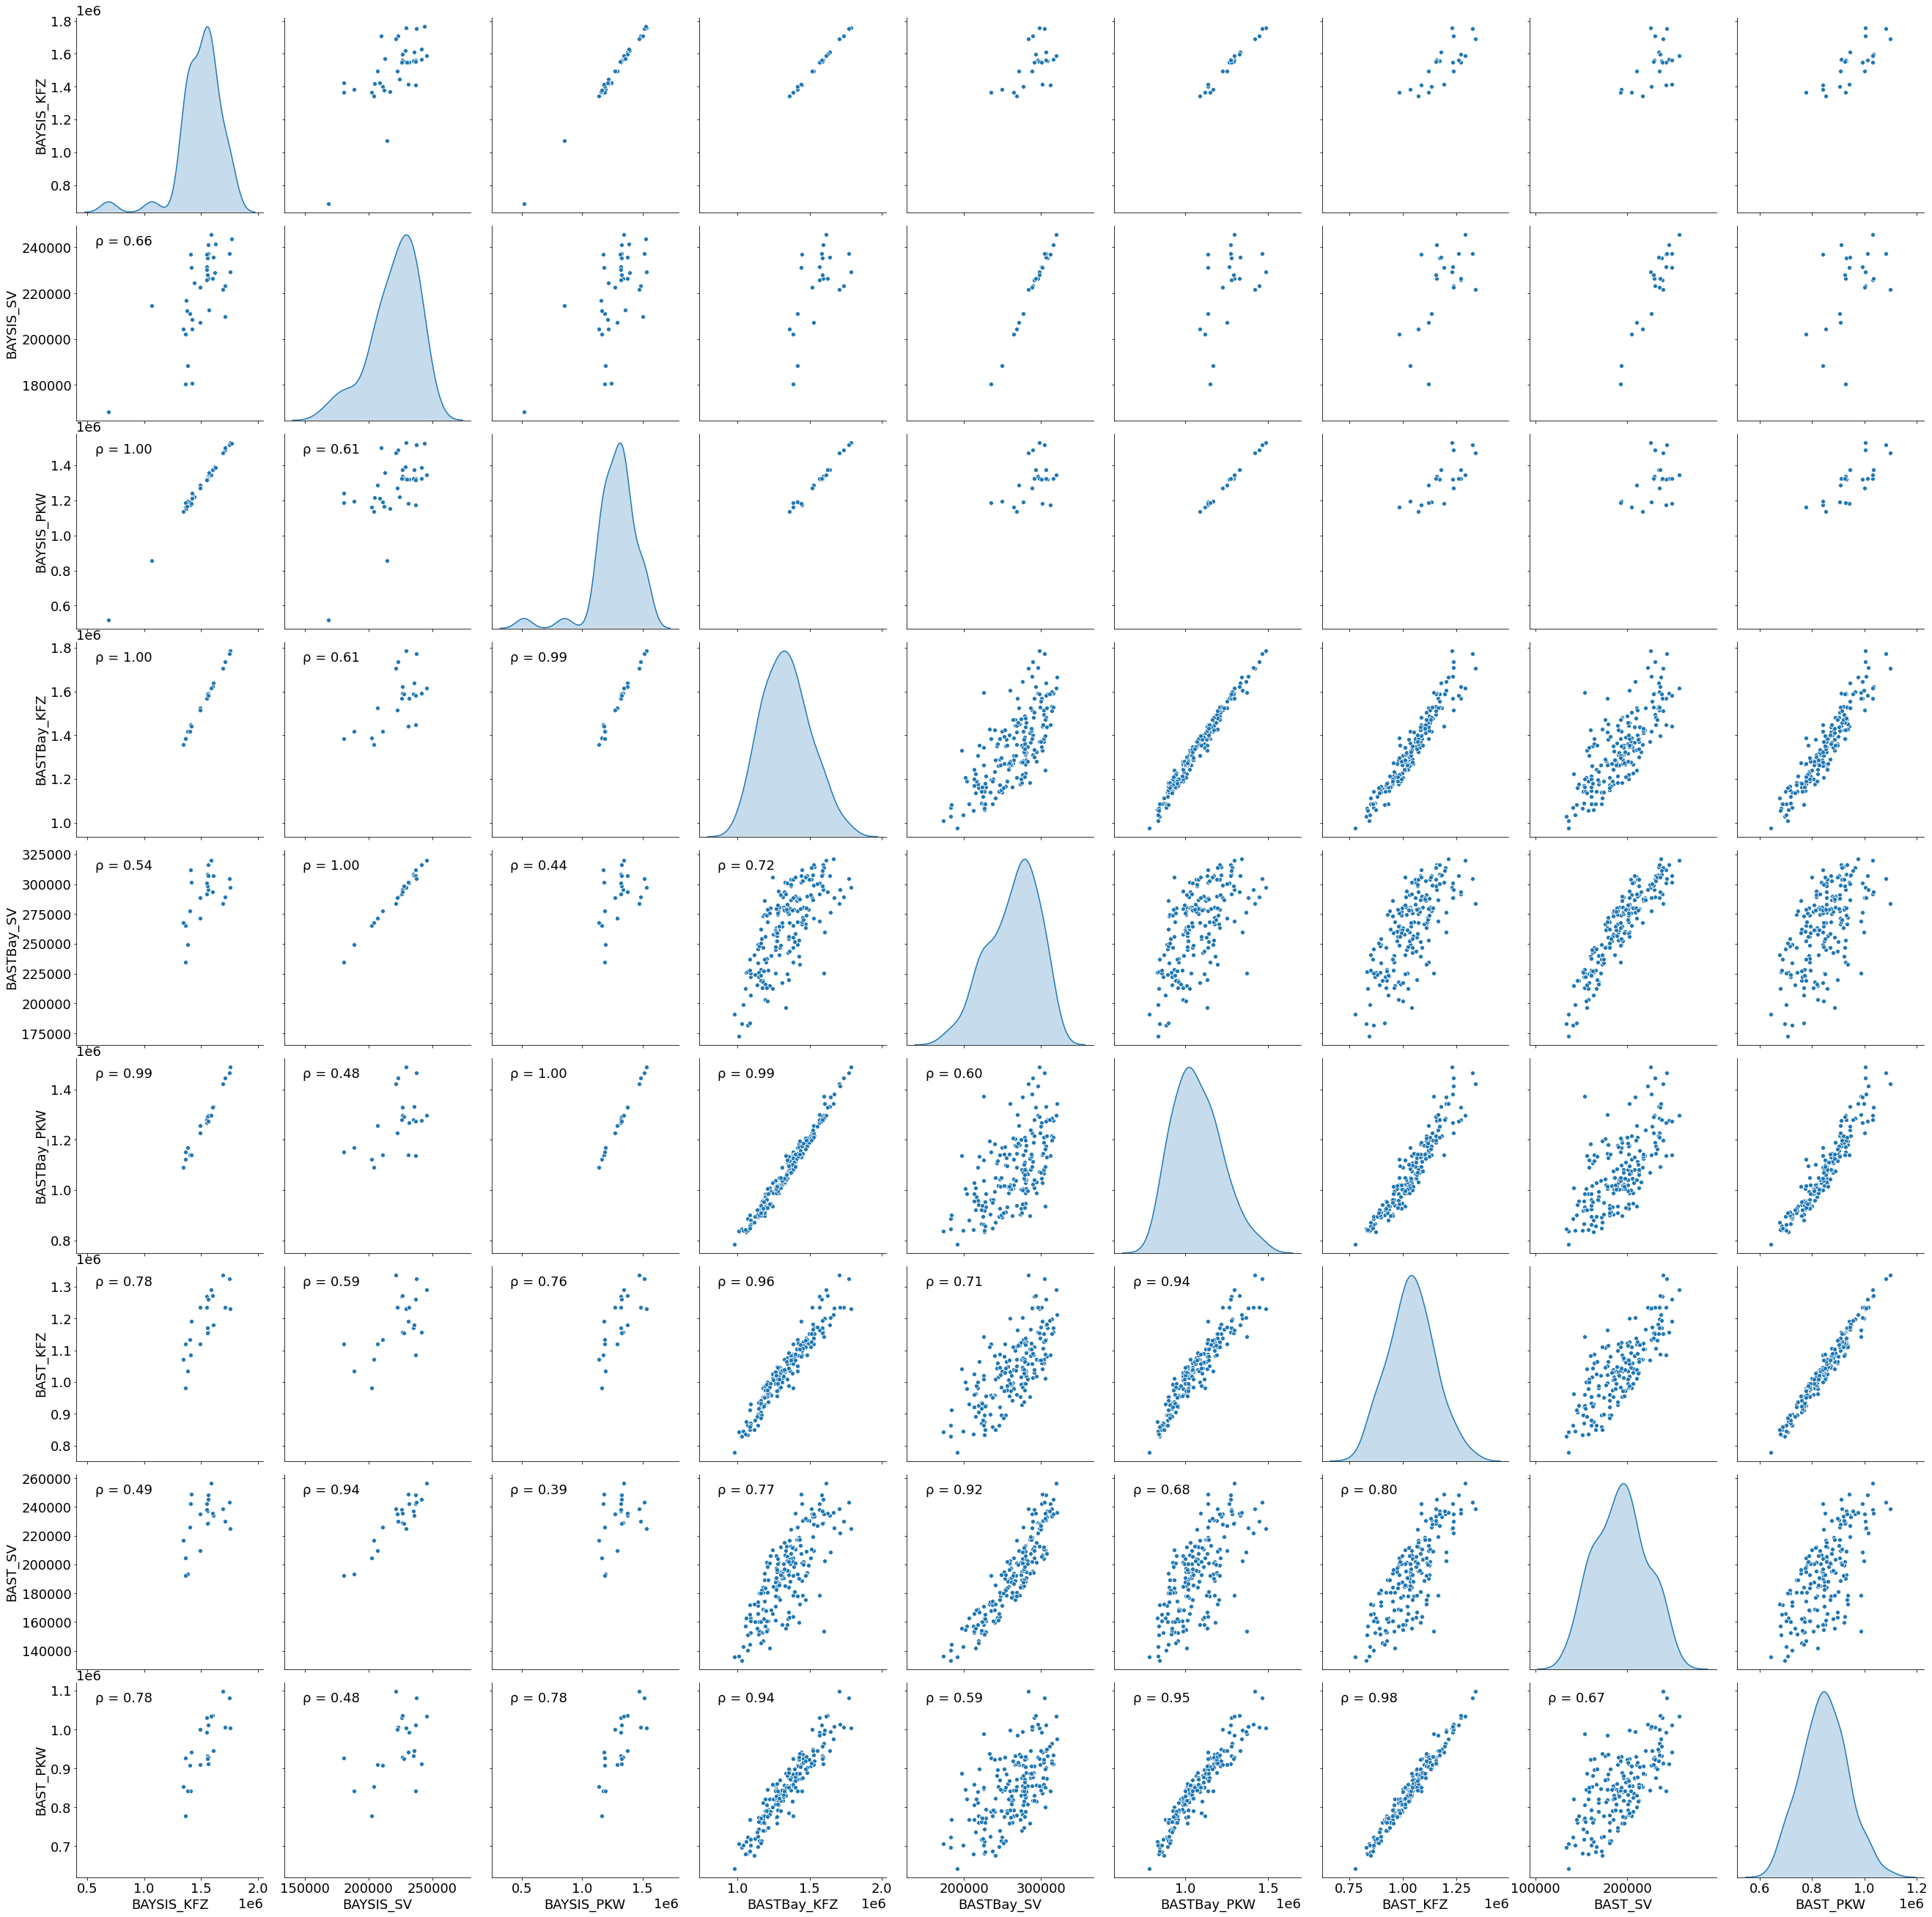

In [4]:
df = pd.concat([df_Baysis, df_BastBay, df_Bast],axis=1)
g = sns.pairplot(df,diag_kind='kde',height=4)
g.map_lower(corrfunc)

## Result
- Strong correlation between Bavarian and German Traffic (also due to the fact that bavarian traffic is included in the german dataset)
- mapping of Bavarian KFZ to German KFZ, Bavarian SV to German SV, Bavarian PKW to German PKW

# Mapping bavarian traffic from BAYSIS on bavarian traffic from BAST
The reason for this mapping
- The BAST data and the BAYSIS data contain the same counting stations 
- Due to the different data availability (BAST: hourly, BAYSIS: monthly) the two datasources seem to have an offset to each other
- This offset can have the reason that SV does not mean the same in both datasets. In BAST SV equals the sum of LKW, BUS, and Sat (Sattelzug). In BAYSIS the content of SV is unclear (E-Mail inquery to BAYSIS on 07.07.2020)

Solution: Mapping of BAYSIS data on Bavarian data from BAST to get a continuous dataset from 2003 until April 2020.

## Create empty dataframe for Bavaria with correct date index

In [5]:
df_bavaria = pd.concat([df_Baysis, df_BastBay], axis=1)
df_bavaria = df_bavaria.sort_index()
for column in df_bavaria: df_bavaria = df_bavaria.drop(column,axis=1)

## KFZ

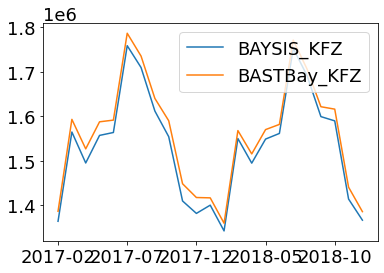

In [6]:
# visualization
df_tmp = pd.concat([df_Baysis[['BAYSIS_KFZ']], df_BastBay[['BASTBay_KFZ']]], axis=1)
df_tmp = df_tmp.dropna(axis=0)
df_tmp.plot()

In [7]:
#mapping
lr_KFZ_Bav = LinearRegression()
lr_KFZ_Bav.fit(df_tmp.BAYSIS_KFZ.values.reshape(-1,1), df_tmp.BASTBay_KFZ)
#predict BAYSIS data from 2018, 2019, and 2020
pred_Bav = lr_KFZ_Bav.predict(df_Baysis.BAYSIS_KFZ.values.reshape(-1,1))

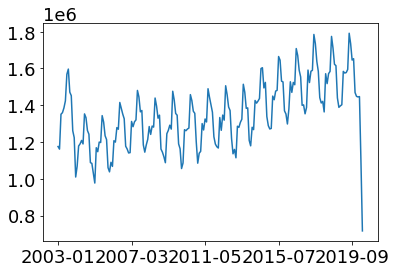

In [8]:
#append BAYSIS predictions on Bavarian BAST values
df_predBav = pd.DataFrame({'pred_Bav': pred_Bav}, index=df_Baysis.index)
df_predBav = pd.concat([df_predBav, df_BastBay[['BASTBay_KFZ']]],axis=1)
df_predBav['KFZ_Bavaria'] = df_predBav.mean(axis=1, skipna=True)
df_predBav = df_predBav.sort_index()
df_predBav['KFZ_Bavaria'].plot()

In [9]:
df_bavaria['KFZ_Bavaria'] = df_predBav['KFZ_Bavaria'].values

## PKW

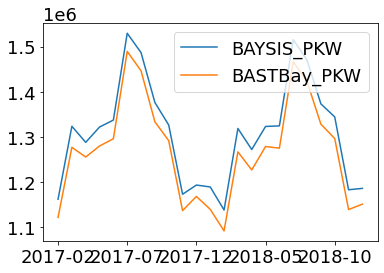

In [10]:
# visualization
df_tmp = pd.concat([df_Baysis[['BAYSIS_PKW']], df_BastBay[['BASTBay_PKW']]], axis=1)
df_tmp = df_tmp.dropna(axis=0)
df_tmp.plot()

In [11]:
#mapping
lr_PKW_Bav = LinearRegression()
lr_PKW_Bav.fit(df_tmp.BAYSIS_PKW.values.reshape(-1,1), df_tmp.BASTBay_PKW)
#predict BAYSIS data from 2018, 2019, and 2020
pred_Bav = lr_PKW_Bav.predict(df_Baysis.BAYSIS_PKW.values.reshape(-1,1))

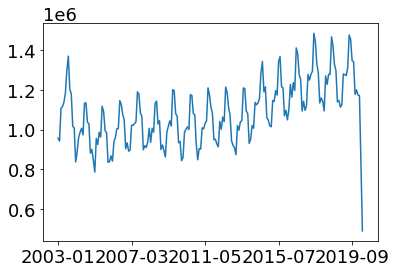

In [12]:
#append BAYSIS predictions on Bavarian BAST values
df_predBav = pd.DataFrame({'pred_Bav': pred_Bav}, index=df_Baysis.index)
df_predBav = pd.concat([df_predBav, df_BastBay[['BASTBay_PKW']]],axis=1)
df_predBav['PKW_Bavaria'] = df_predBav.mean(axis=1, skipna=True)
df_predBav = df_predBav.sort_index()
df_predBav['PKW_Bavaria'].plot()

In [13]:
df_bavaria['PKW_Bavaria'] = df_predBav['PKW_Bavaria'].values

## SV

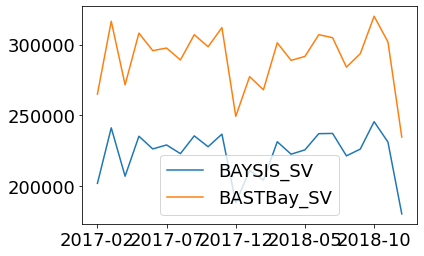

In [14]:
# visualization
df_tmp = pd.concat([df_Baysis[['BAYSIS_SV']], df_BastBay[['BASTBay_SV']]], axis=1)
df_tmp = df_tmp.dropna(axis=0)
df_tmp.plot()

In [15]:
#mapping
lr_SV_Bav = LinearRegression()
lr_SV_Bav.fit(df_tmp.BAYSIS_SV.values.reshape(-1,1), df_tmp.BASTBay_SV)
#predict BAYSIS data from 2018, 2019, and 2020
pred_Bav = lr_SV_Bav.predict(df_Baysis.BAYSIS_SV.values.reshape(-1,1))

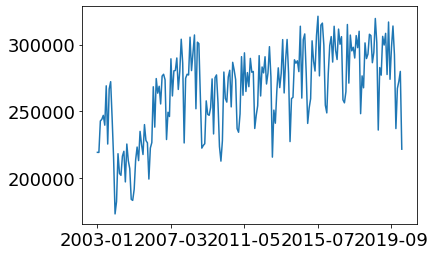

In [16]:
#append BAYSIS predictions on Bavarian BAST values
df_predBav = pd.DataFrame({'pred_Bav': pred_Bav}, index=df_Baysis.index)
df_predBav = pd.concat([df_predBav, df_BastBay[['BASTBay_SV']]],axis=1)
df_predBav['SV_Bavaria'] = df_predBav.mean(axis=1, skipna=True)
df_predBav = df_predBav.sort_index()
df_predBav['SV_Bavaria'].plot()

In [17]:
df_bavaria['SV_Bavaria'] = df_predBav['SV_Bavaria'].values

## Investigate reliability of result
- PKW = KFZ - SV is calculated right at the beginning for BAST, BAST Bavaria, and BAYSIS
- now it should work: KFZ = PKW + SV

439.2478078782532

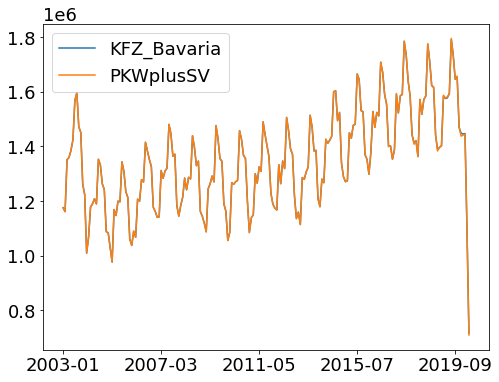

In [18]:
df_bavaria_test = df_bavaria.copy()
df_bavaria_test['PKWplusSV'] = df_bavaria_test['PKW_Bavaria'] + df_bavaria_test['SV_Bavaria']
df_bavaria_test = df_bavaria_test.drop(['PKW_Bavaria', 'SV_Bavaria'],axis=1)
df_bavaria_test.plot(figsize=(8,6))

#mean difference
#only about 440 vehicles per month per counting station -> very good result
np.mean(abs(df_bavaria_test['PKWplusSV'] - df_bavaria_test['KFZ_Bavaria'])) 


In [19]:
df_bavaria.head()

,KFZ_Bavaria,PKW_Bavaria,SV_Bavaria
2003-01,1.175458e+06,9.563730e+05,219084.585526
2003-02,1.161299e+06,9.422598e+05,219039.276316
2003-03,1.350965e+06,1.108350e+06,242614.815789
2003-04,1.359519e+06,1.115646e+06,243873.019737
2003-05,1.385195e+06,1.138355e+06,246839.861842


# Mapping Bavaria on German Traffic with Linear Regression

## Create empty dataframe for Germany

In [20]:
df_germany = df_bavaria.copy()
df_germany = df_bavaria.sort_index()
for column in df_germany: df_germany = df_germany.drop(column,axis=1)

## KFZ

R2 and RMSE for whole dataset
r2:  0.92
rmse:  29551.78
relative rmse to mean of labels:  2.84 %


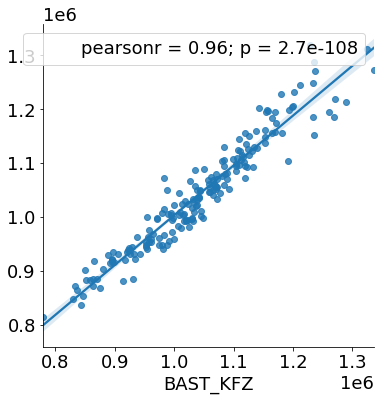

In [21]:
# train on whole available dataset
lr_KFZ = LinearRegression()
df_tmp = pd.concat([df_Bast[['BAST_KFZ']], df_bavaria[['KFZ_Bavaria']]], axis=1)
df_tmp = df_tmp.dropna(axis=0)
lr_KFZ.fit(df_tmp.KFZ_Bavaria.values.reshape(-1, 1), df_tmp.BAST_KFZ)

# test on train data
PredGer_FromBASTBay = lr_KFZ.predict(df_tmp.KFZ_Bavaria.values.reshape(-1, 1))

print('R2 and RMSE for whole dataset')
r2 = round(lr_KFZ.score(df_BastBay.BASTBay_KFZ.values.reshape(-1, 1), df_tmp.BAST_KFZ),2)
rmse = round(sqrt(mean_squared_error(df_tmp.BAST_KFZ, PredGer_FromBASTBay)),2)
rel_rmse = np.round(100 * rmse/df_Bast.BAST_KFZ.mean(),2)
print('r2: ', r2)
print('rmse: ', rmse)
print('relative rmse to mean of labels: ', rel_rmse, '%')

g = sns.JointGrid(x=df_Bast.BAST_KFZ,y=PredGer_FromBASTBay, ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

### Add to Germany dataframe

In [22]:
df_germany['M_KFZ'] = lr_KFZ.predict(df_bavaria.KFZ_Bavaria.values.reshape(-1, 1))

## SV

R2 and RMSE for whole dataset
r2:  0.84
rmse:  10972.68
relative rmse to mean of labels:  5.69 %


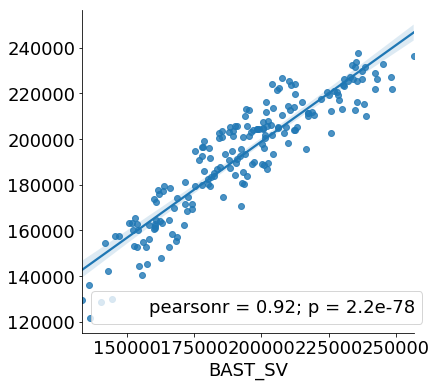

In [23]:
# train on whole available dataset
lr_SV = LinearRegression()
df_tmp = pd.concat([df_Bast[['BAST_SV']], df_bavaria[['SV_Bavaria']]], axis=1)
df_tmp = df_tmp.dropna(axis=0)
lr_SV.fit(df_tmp.SV_Bavaria.values.reshape(-1, 1), df_tmp.BAST_SV)

# test on train data
PredGer_FromBASTBay = lr_SV.predict(df_tmp.SV_Bavaria.values.reshape(-1, 1))

print('R2 and RMSE for whole dataset')
r2 = round(lr_SV.score(df_BastBay.BASTBay_SV.values.reshape(-1, 1), df_tmp.BAST_SV),2)
rmse = round(sqrt(mean_squared_error(df_tmp.BAST_SV, PredGer_FromBASTBay)),2)
rel_rmse = np.round(100 * rmse/df_Bast.BAST_SV.mean(),2)
print('r2: ', r2)
print('rmse: ', rmse)
print('relative rmse to mean of labels: ', rel_rmse, '%')

g = sns.JointGrid(x=df_Bast.BAST_SV,y=PredGer_FromBASTBay, ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

### Add to Germany dataframe

In [24]:
df_germany['M_SV'] = lr_SV.predict(df_bavaria.SV_Bavaria.values.reshape(-1, 1))

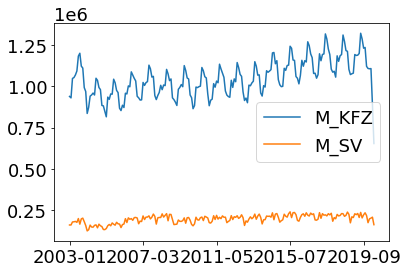

In [25]:
df_germany.plot()

## PKW

R2 and RMSE for whole dataset
r2:  0.9
rmse:  27593.68
relative rmse to mean of labels:  3.25 %


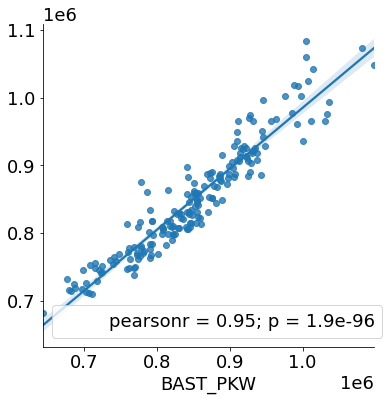

In [26]:
# train on whole available dataset
lr_PKW = LinearRegression()
df_tmp = pd.concat([df_Bast[['BAST_PKW']], df_bavaria[['PKW_Bavaria']]], axis=1)
df_tmp = df_tmp.dropna(axis=0)
lr_PKW.fit(df_tmp.PKW_Bavaria.values.reshape(-1, 1), df_tmp.BAST_PKW)

# test on train data
PredGer_FromBASTBay = lr_PKW.predict(df_tmp.PKW_Bavaria.values.reshape(-1, 1))

print('R2 and RMSE for whole dataset')
r2 = round(lr_PKW.score(df_BastBay.BASTBay_PKW.values.reshape(-1, 1), df_tmp.BAST_PKW),2)
rmse = round(sqrt(mean_squared_error(df_tmp.BAST_PKW, PredGer_FromBASTBay)),2)
rel_rmse = np.round(100 * rmse/df_Bast.BAST_PKW.mean(),2)
print('r2: ', r2)
print('rmse: ', rmse)
print('relative rmse to mean of labels: ', rel_rmse, '%')

g = sns.JointGrid(x=df_Bast.BAST_PKW,y=PredGer_FromBASTBay, ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

### Add to Germany dataframe

In [27]:
df_germany['M_LV'] = lr_PKW.predict(df_bavaria.PKW_Bavaria.values.reshape(-1, 1))

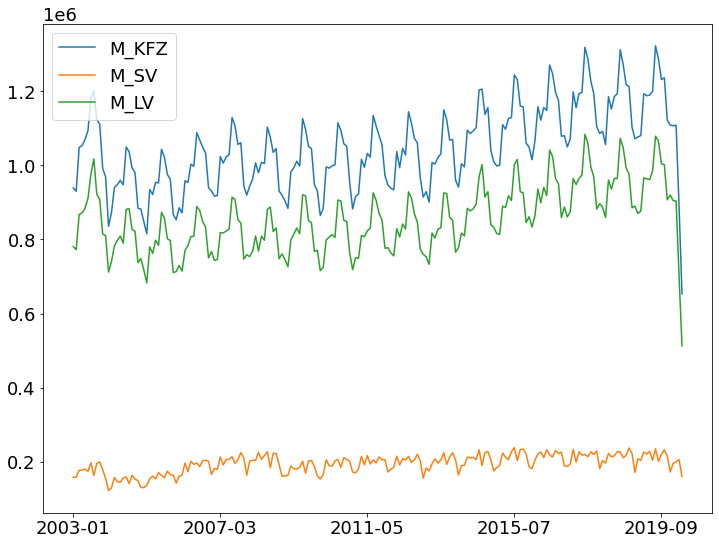

In [28]:
df_germany.plot(figsize=(12,9))

# Use mobility report for months April, May, June 2020

In [29]:
df_Bast_MR.head()

,M_BASTMobRep_DiffRatio_KFZ,M_BASTMobRep_DiffRatio_SV,M_BASTMobRep_DiffRatio_LV
date,,,
2020-03,-0.435000,-0.065000,-0.500000
2020-04,-0.455294,-0.252941,-0.491765
2020-05,-0.218148,-0.136296,-0.231852
2020-06,-0.074000,-0.045600,-0.076000


In [30]:
df_germany = df_germany.drop('2020-04', axis=0)

In [31]:
dates = ['2020-04', '2020-05', '2020-06']
val_KFZ = [(1+df_Bast_MR['M_BASTMobRep_DiffRatio_KFZ']['2020-04']) * df_germany['M_KFZ']['2020-02'],
           (1+df_Bast_MR['M_BASTMobRep_DiffRatio_KFZ']['2020-05']) * df_germany['M_KFZ']['2020-02'],
           (1+df_Bast_MR['M_BASTMobRep_DiffRatio_KFZ']['2020-06']) * df_germany['M_KFZ']['2020-02']
          ]

val_LV = [(1+df_Bast_MR['M_BASTMobRep_DiffRatio_LV']['2020-04']) * df_germany['M_LV']['2020-02'],
           (1+df_Bast_MR['M_BASTMobRep_DiffRatio_LV']['2020-05']) * df_germany['M_LV']['2020-02'],
           (1+df_Bast_MR['M_BASTMobRep_DiffRatio_LV']['2020-06']) * df_germany['M_LV']['2020-02']
          ]


val_SV = [(1+df_Bast_MR['M_BASTMobRep_DiffRatio_SV']['2020-04']) * df_germany['M_SV']['2020-02'],
        (1+df_Bast_MR['M_BASTMobRep_DiffRatio_SV']['2020-05']) * df_germany['M_SV']['2020-02'],
        (1+df_Bast_MR['M_BASTMobRep_DiffRatio_SV']['2020-06']) * df_germany['M_SV']['2020-02']
        ]

df_tmp = pd.DataFrame({'M_KFZ': val_KFZ, 'M_LV': val_LV, 'M_SV': val_SV}, index=dates)

df_germany = df_germany.append(df_tmp)



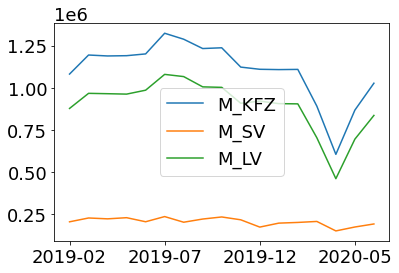

In [32]:
df_germany[df_germany.index > '2019-01'].plot()

# Save features

In [33]:
df_germany.index.name = 'date'
df_germany.to_csv('../data/mobility/M_BastBaysisBastMR_Feature_Ger_Cor.csv')